In [1]:
from pathlib import Path

import pandas as pd

data_path = Path.cwd() / "raw_data_2" / "Luftqualitaet_Zusammenfassung.csv"

df = pd.read_csv(data_path, encoding="UTF-8", sep=";")
df = df.rename(
    columns={
        "Stationscode": "code",
        "Stationsname": "name",
        "Stationsumgebung": "area",
        "Art der Station": "type",
        "Timestamp": "timestamp",
        "Einheit": "unit",
        "Feinstaub (PM₁₀)": "pm10",
        "Feinstaub (PM₂,₅)": "pm25",
        "Kohlenmonoxid (CO)": "co",
        "Ozon (O₃)": "o3",
        "Schwefeldioxid (SO₂)": "so2",
        "Stickstoffdioxid (NO₂)": "no2",
    }
)
df = df.drop(columns=["co"])

# to numeric, coerce errors to NaN
pollutant_cols = ["pm10", "pm25", "o3", "so2", "no2"]
for col in pollutant_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# to datetime, coerce errors to NaT
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["time"] = df["timestamp"].dt.time
df["date"] = df["timestamp"].dt.date

df.head()

C:\Users\L\AppData\Local\Temp\ipykernel_1152\3963767702.py:7: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding="UTF-8", sep=";")


,code,name,area,type,timestamp,unit,pm10,pm25,o3,so2,no2,time,date
0,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 01:00:00,µg/m³,NaN,NaN,54.0,4.0,8.0,01:00:00,2023-01-01
1,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 02:00:00,µg/m³,NaN,NaN,59.0,2.0,4.0,02:00:00,2023-01-01
2,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 03:00:00,µg/m³,NaN,NaN,59.0,1.0,4.0,03:00:00,2023-01-01
3,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 04:00:00,µg/m³,NaN,NaN,60.0,1.0,4.0,04:00:00,2023-01-01
4,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 05:00:00,µg/m³,NaN,NaN,61.0,NaN,4.0,05:00:00,2023-01-01


In [2]:
after_newyear_df = df[df["date"] > pd.to_datetime("2023-01-01").date()]

In [3]:
def get_hightimes(df, pollutant):
    max_df = df.groupby(["code", "date"])[pollutant].max().dropna()
    return df.merge(max_df, on=["code", "date", pollutant], how="right")

In [4]:
SHOW_N = 6

for pollutant in pollutant_cols:
    pollutant_df = get_hightimes(df, pollutant)
    print(pollutant_df.info())
    print(f"Highest {pollutant} values:")
    print(f"{pollutant_df['timestamp'].dt.hour.mean():.3f}")
    print(f"{pollutant_df['timestamp'].dt.hour.median()}")

    for time, count in list(pollutant_df["time"].value_counts().items())[:SHOW_N]:
        mean = pollutant_df[pollutant_df["time"] == time][pollutant].mean()
        median = pollutant_df[pollutant_df["time"] == time][pollutant].median()
        std = pollutant_df[pollutant_df["time"] == time][pollutant].std()
        print(f"{time} ({count}): {mean:.3f} (median: {median:.3f}, std: {std:.3f})")
    
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198142 entries, 0 to 198141
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   code       198142 non-null  object        
 1   name       198142 non-null  object        
 2   area       198142 non-null  object        
 3   type       198142 non-null  object        
 4   timestamp  198142 non-null  datetime64[ns]
 5   unit       198142 non-null  object        
 6   pm10       198142 non-null  float64       
 7   pm25       150751 non-null  float64       
 8   o3         128208 non-null  float64       
 9   so2        28982 non-null   float64       
 10  no2        184324 non-null  float64       
 11  time       198142 non-null  object        
 12  date       198142 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(7)
memory usage: 19.7+ MB
None
Highest pm10 values:
12.441
12.0
23:00:00 (17297): 19.434 (median: 17.000, std: 12.319)
01:0

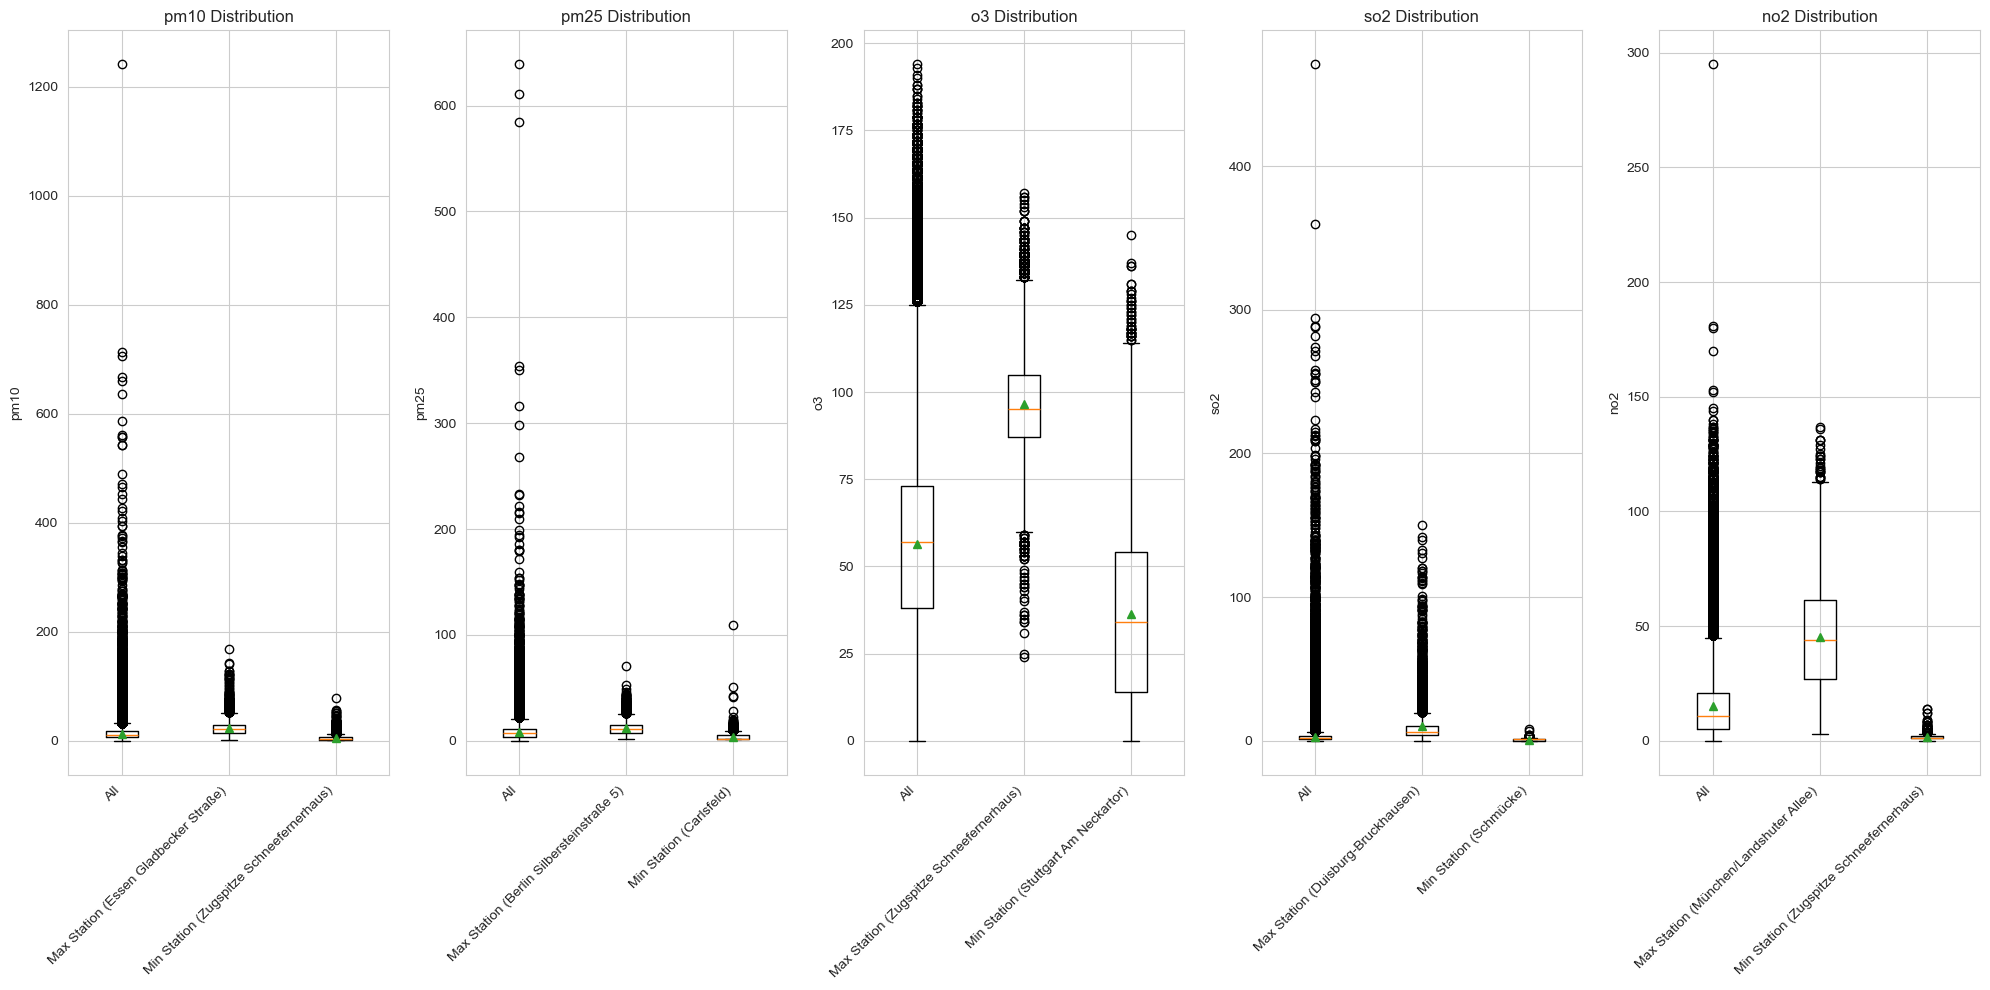

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

after_newyear_df = df[df["date"] > pd.to_datetime("2023-01-01").date()]
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for i, col in enumerate(pollutant_cols):
    ax = axes[i]

    max_station = after_newyear_df[["name", col]].groupby("name").mean().dropna().idxmax().values[0]
    min_station = after_newyear_df[["name", col]].groupby("name").mean().dropna().idxmin().values[0]

    data = {
        "All": after_newyear_df[col].dropna(),
        f"Max Station ({max_station})": after_newyear_df[after_newyear_df["name"] == max_station][col].dropna(),
        f"Min Station ({min_station})": after_newyear_df[after_newyear_df["name"] == min_station][col].dropna(),
    }

    ax.boxplot(data.values(), showmeans=True)
    ax.set(
        ylabel=col,
        title=f"{col} Distribution"
    )
    ax.set_xticklabels(data.keys(), rotation=45, ha='right')
fig.tight_layout()

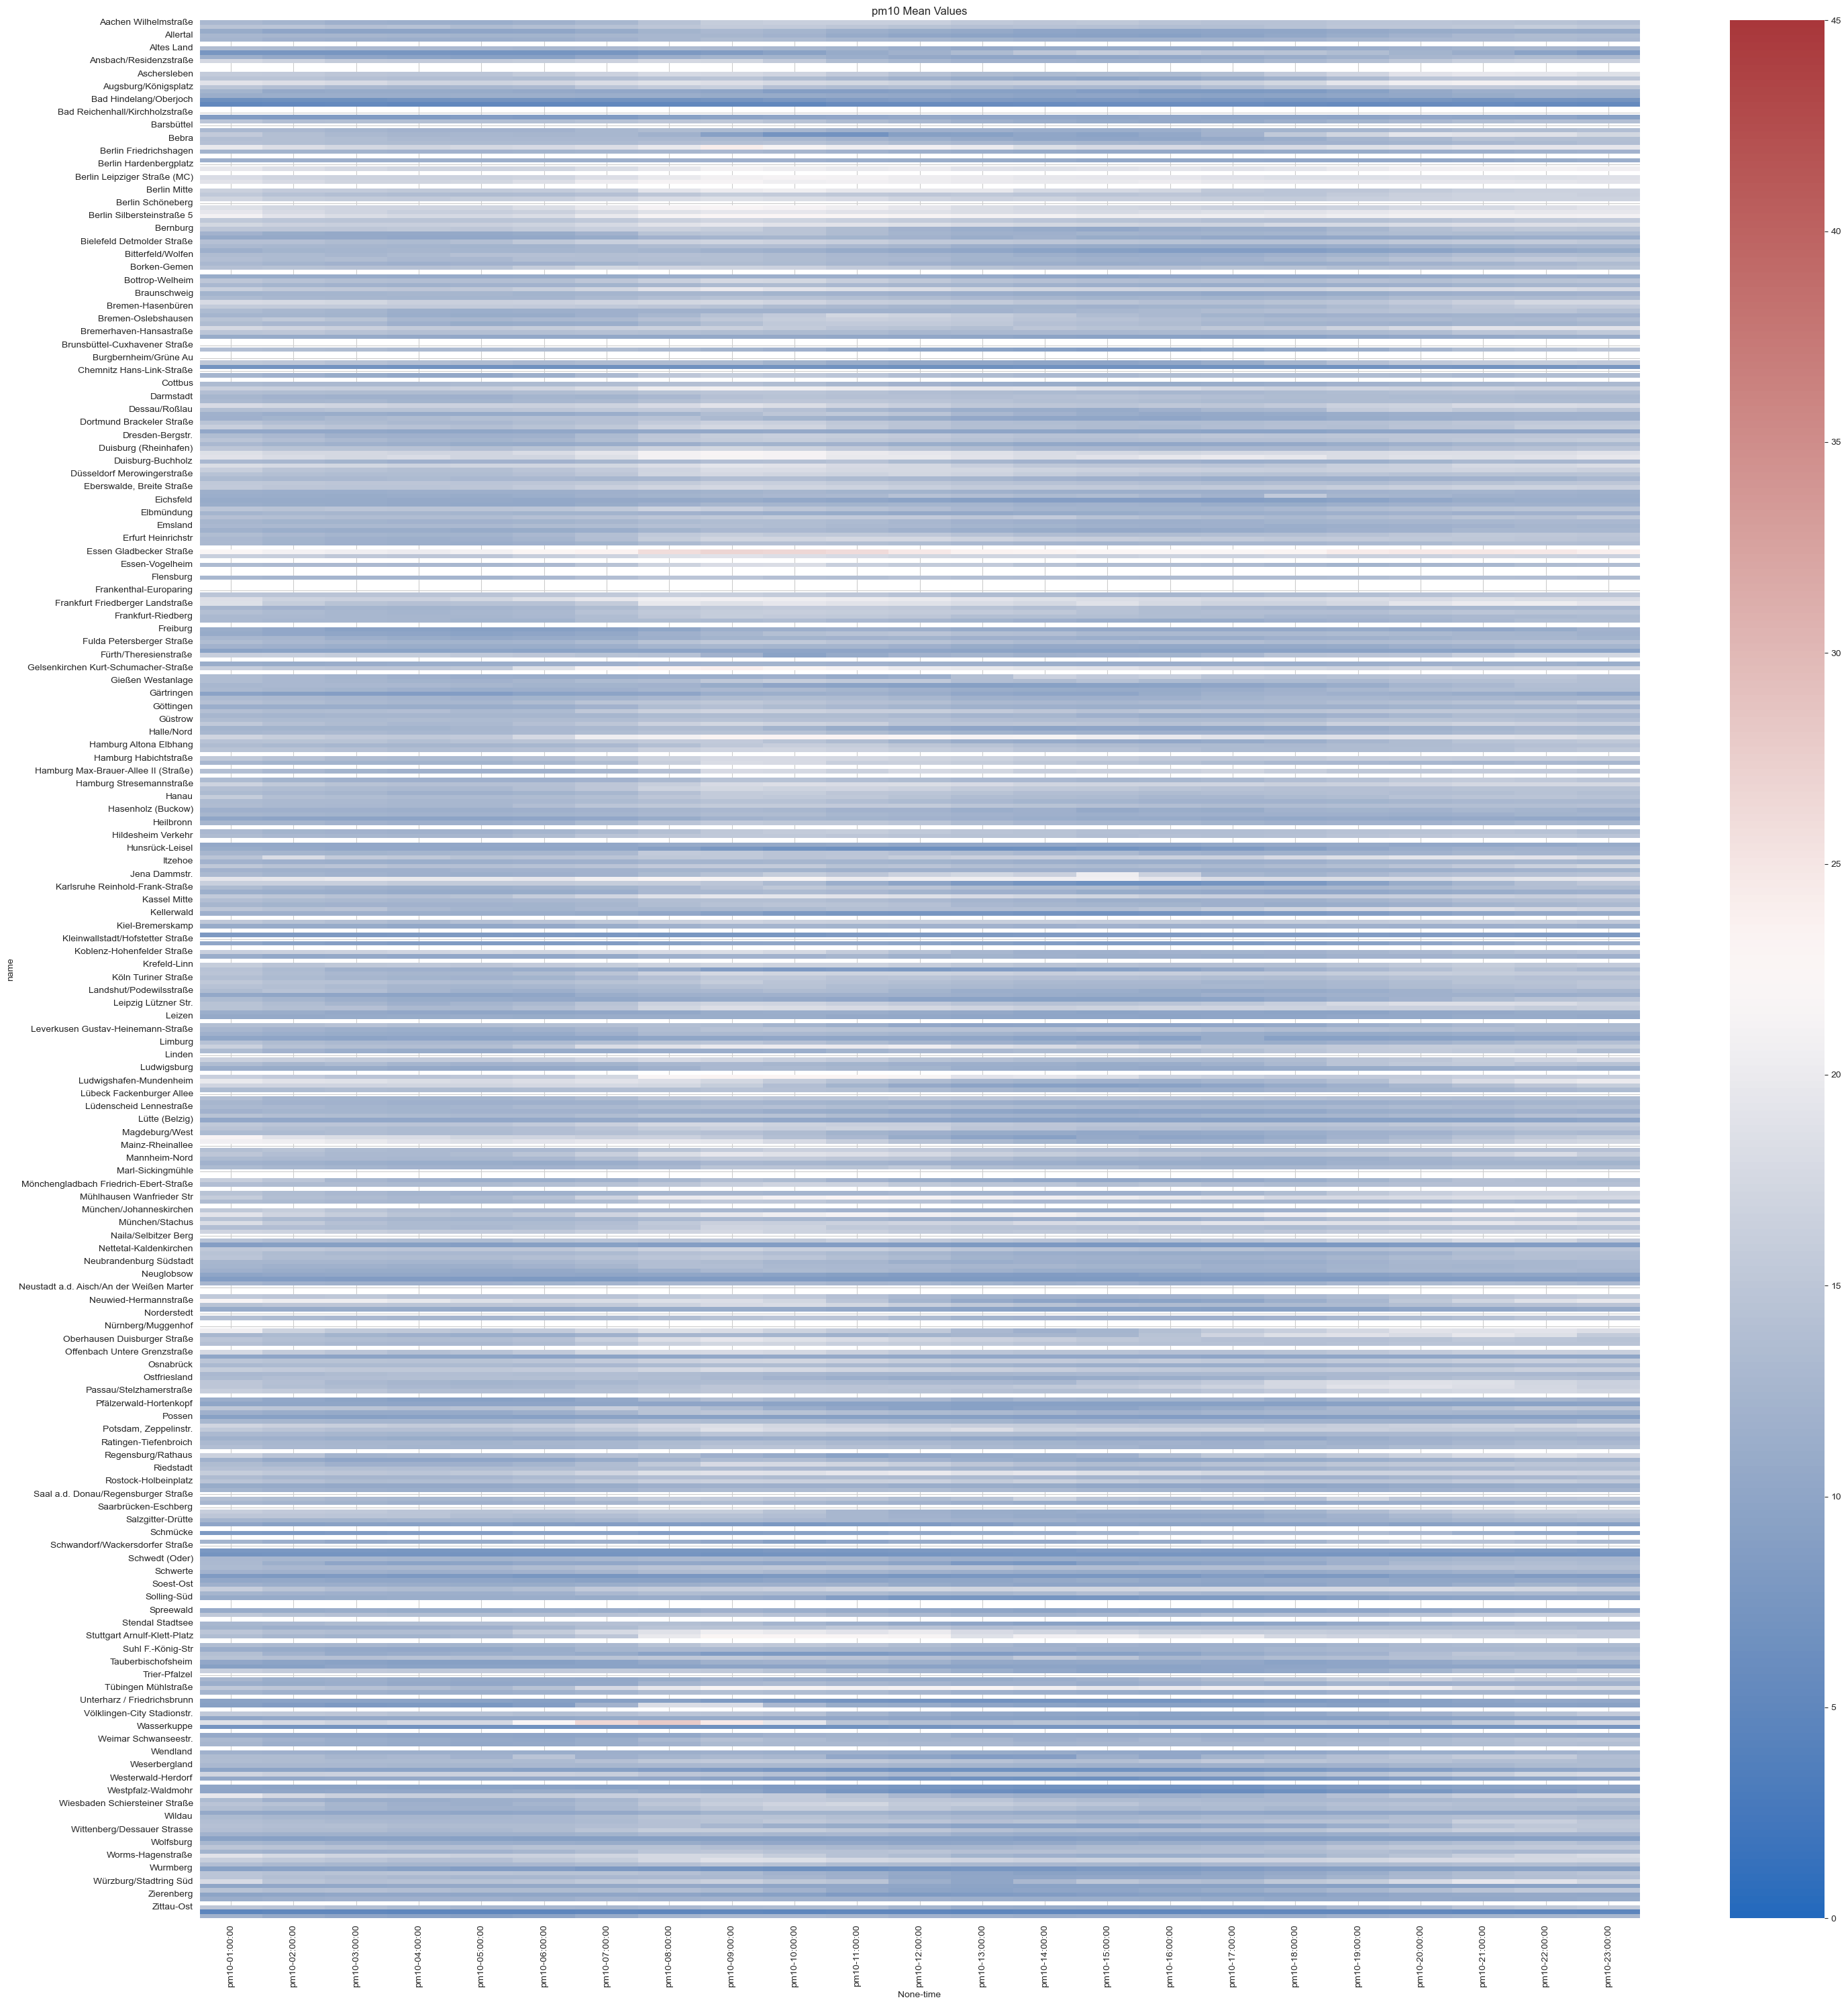

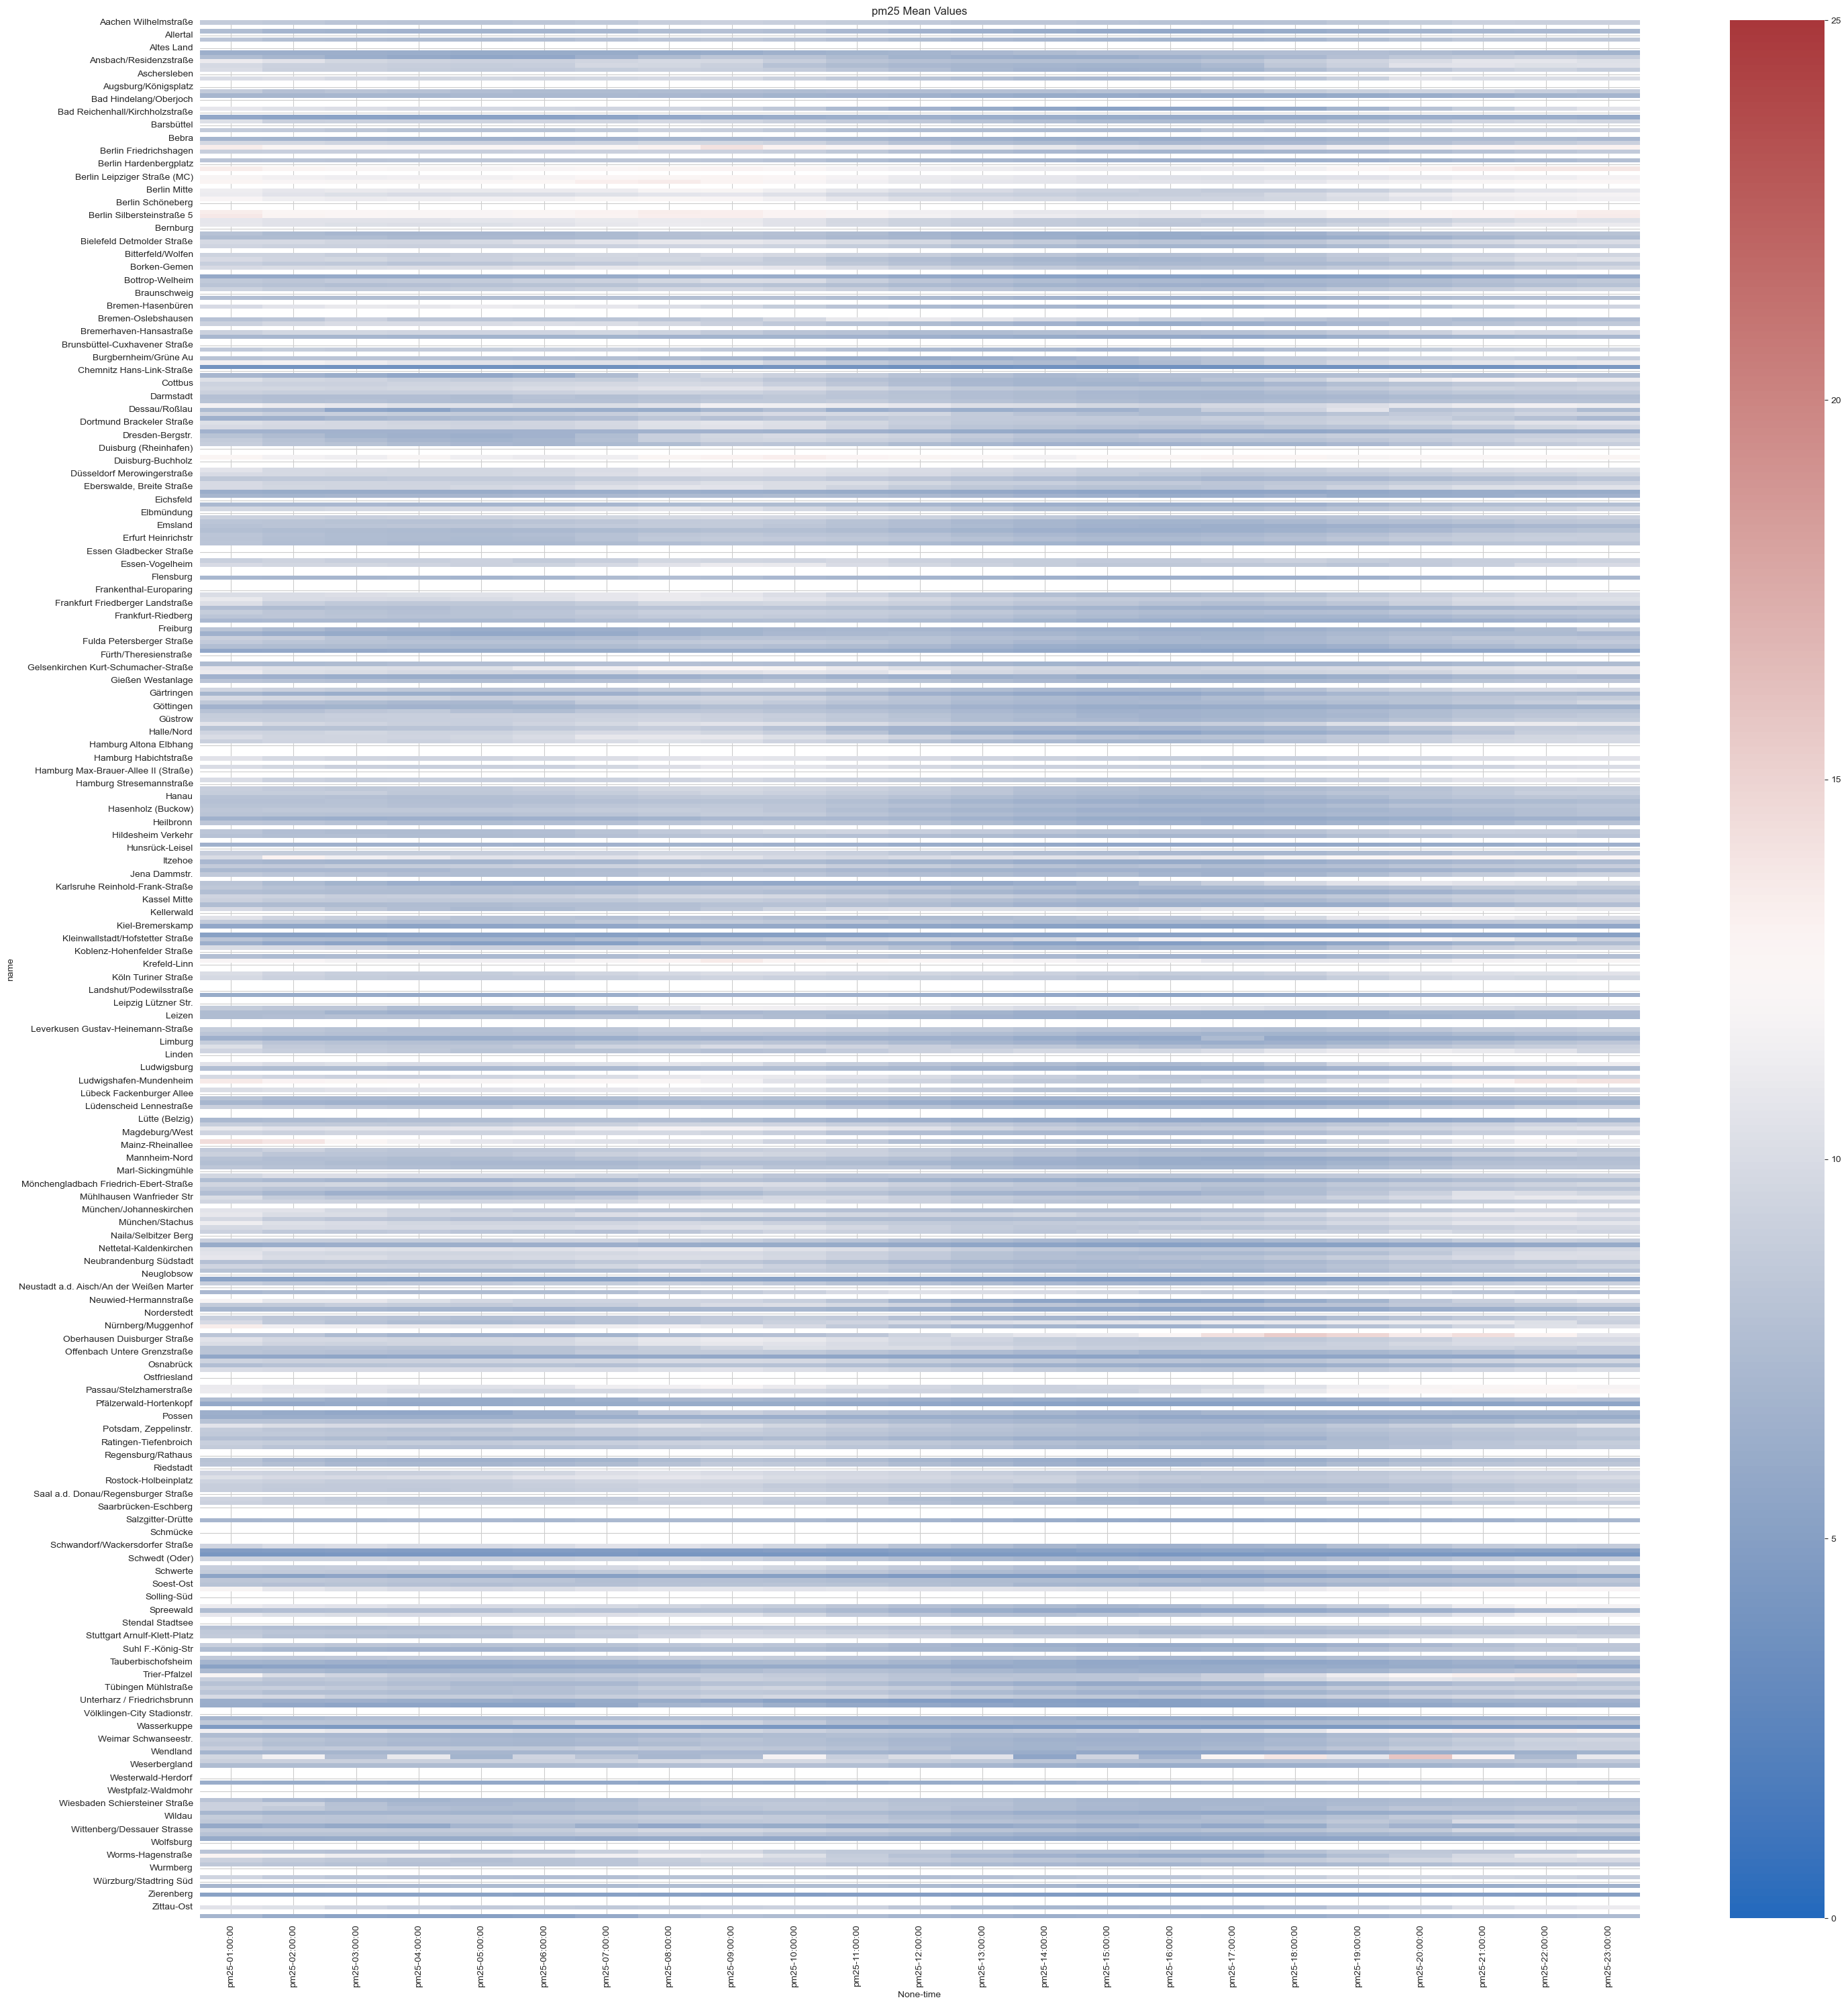

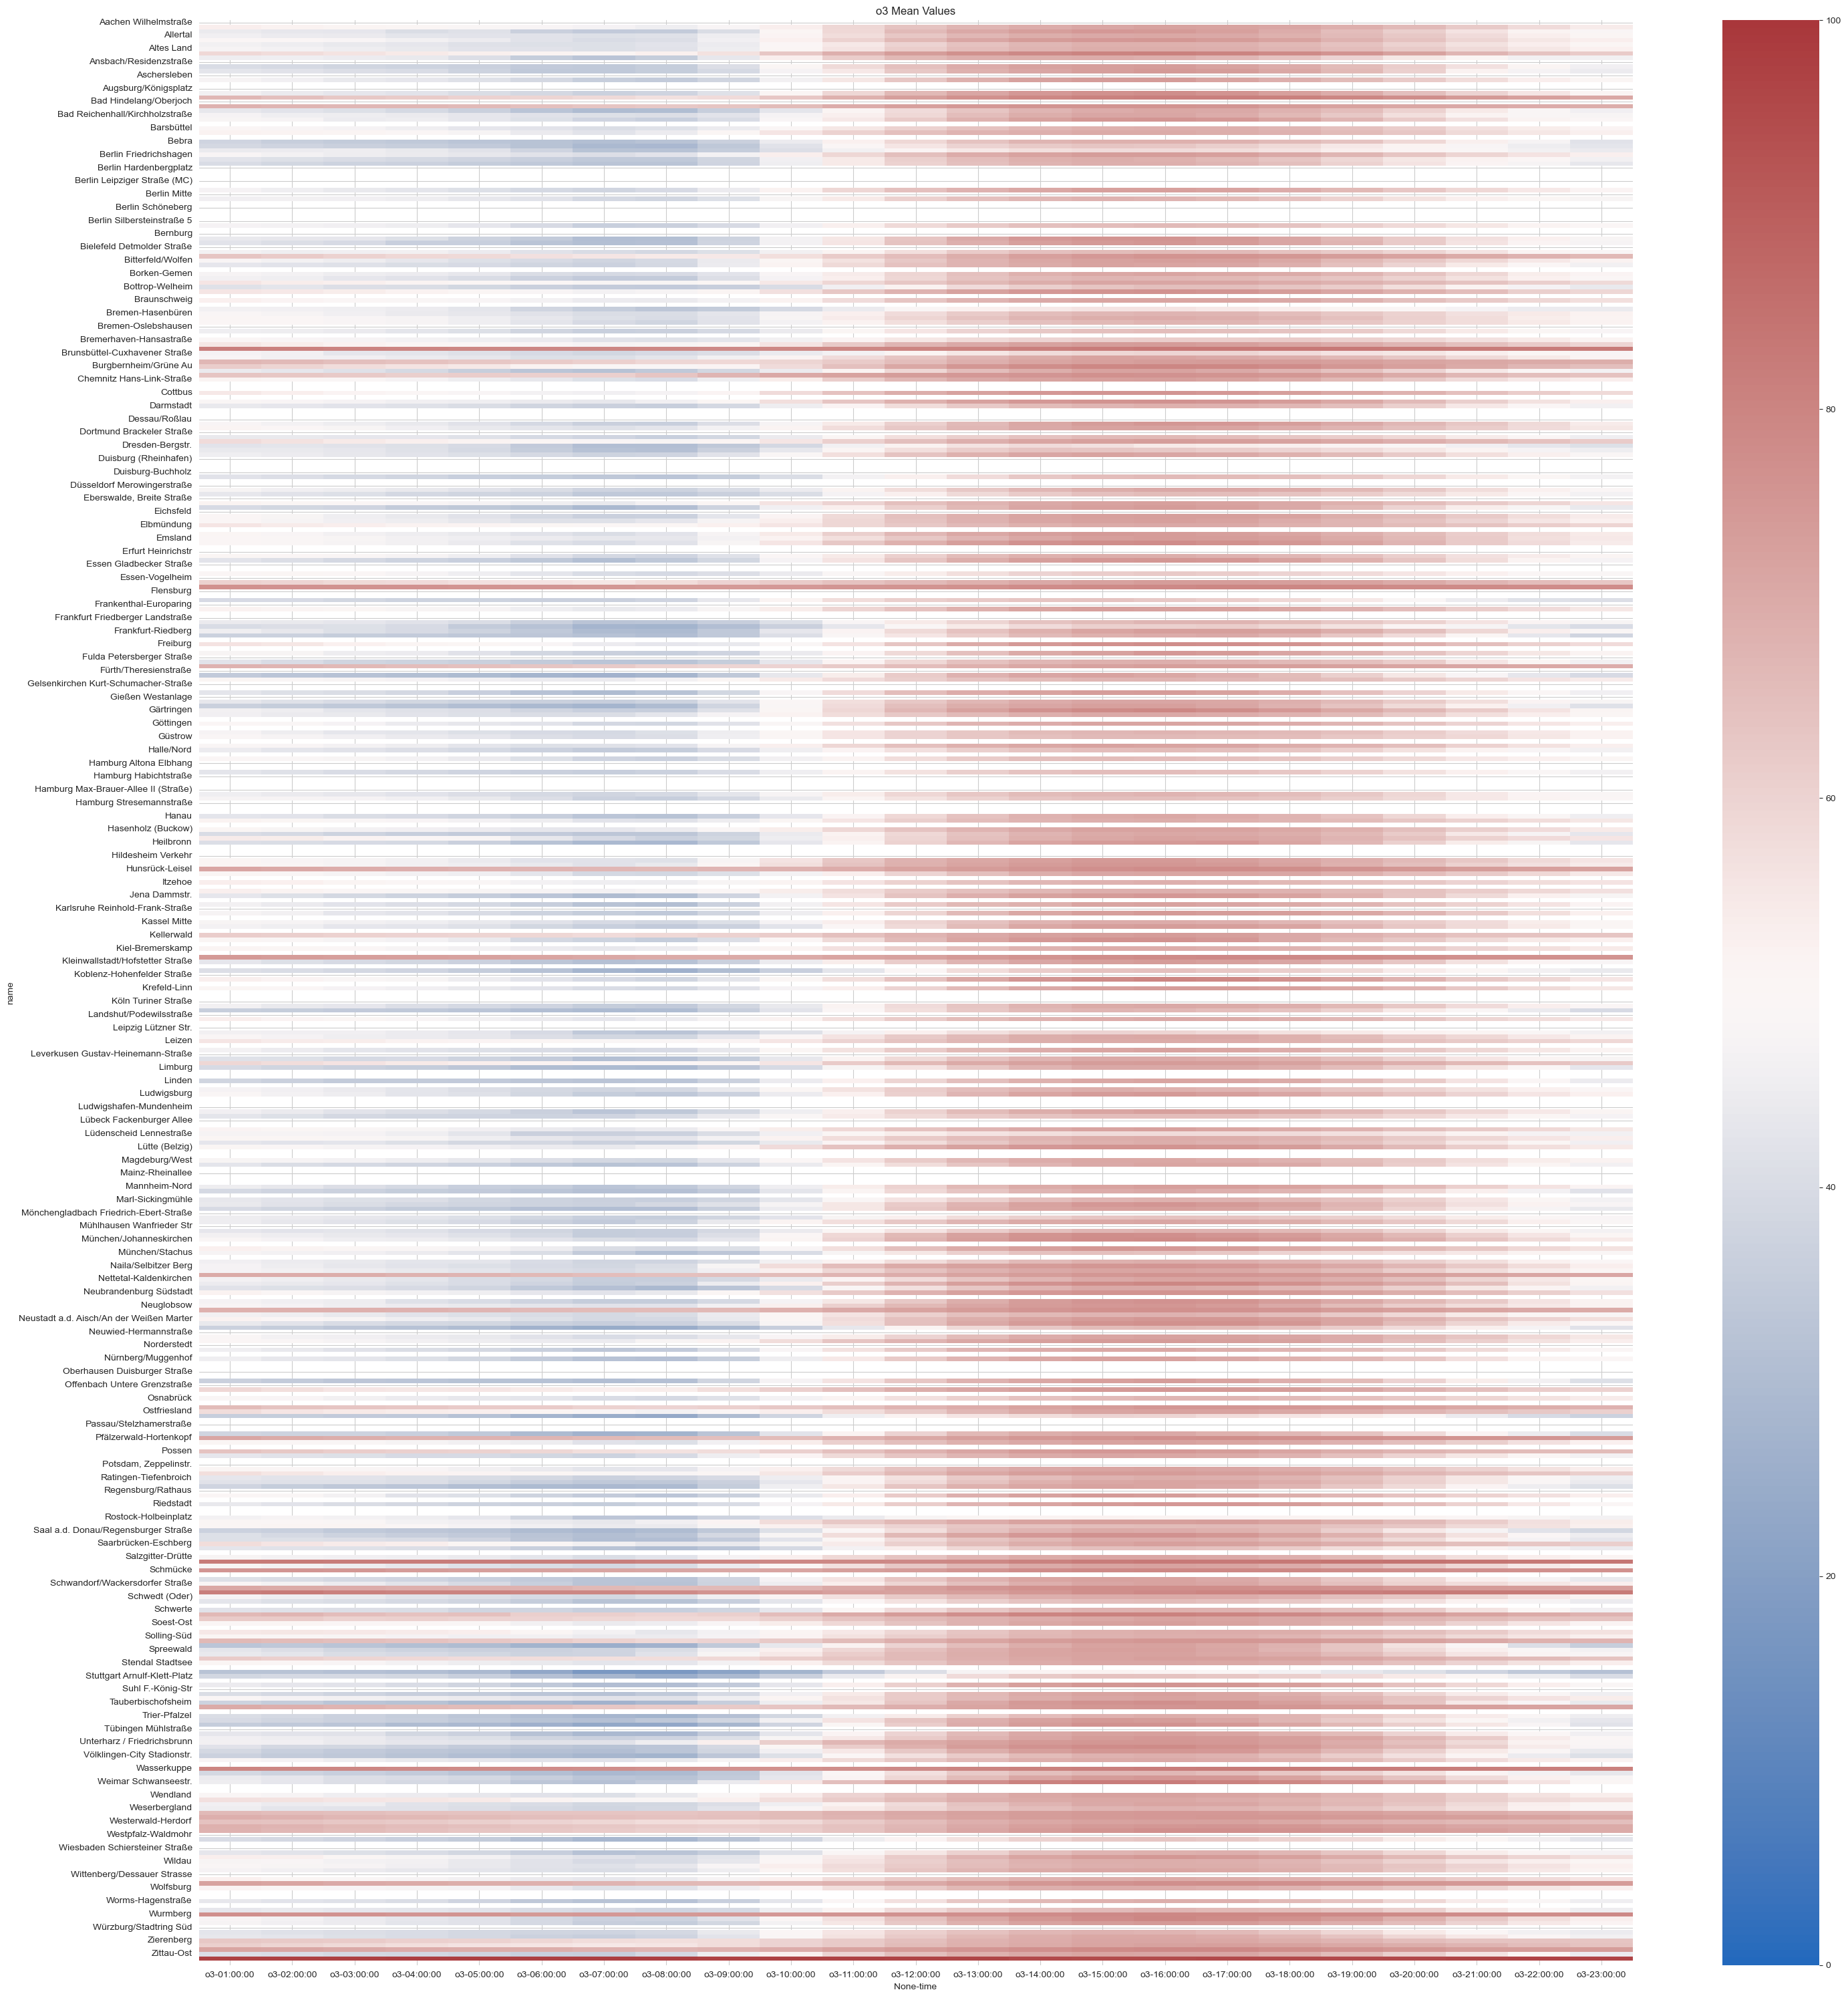

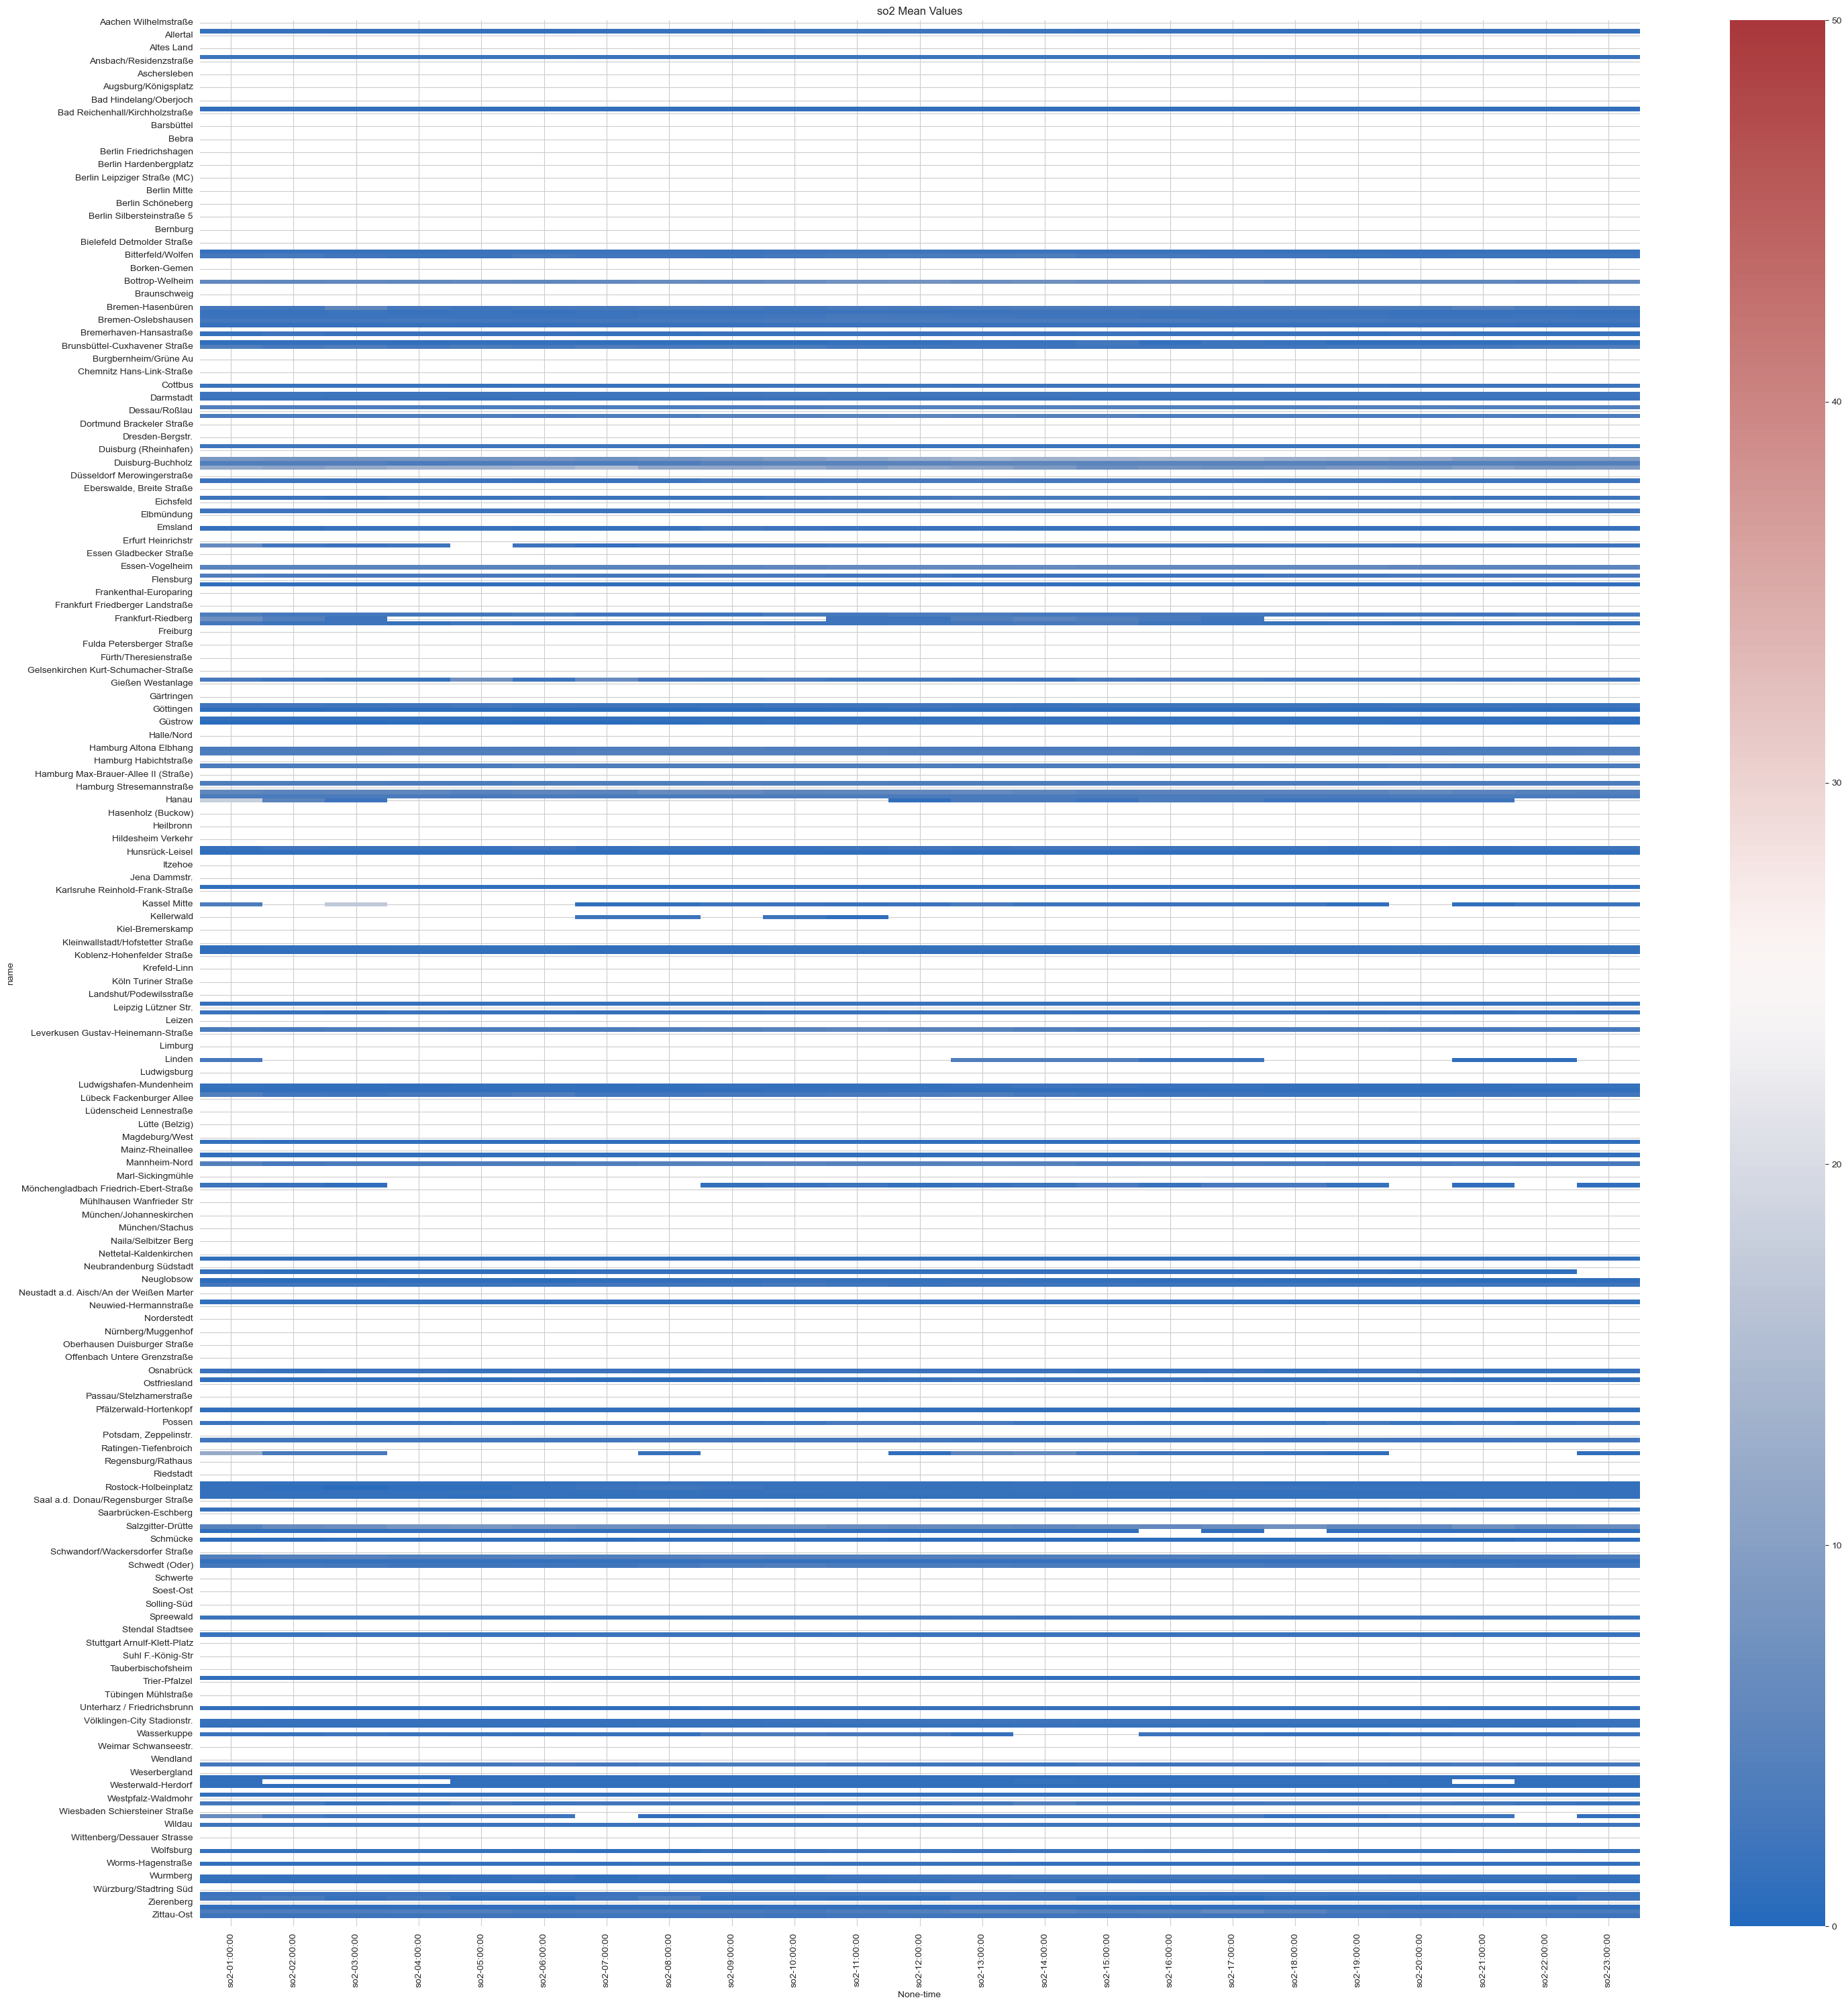

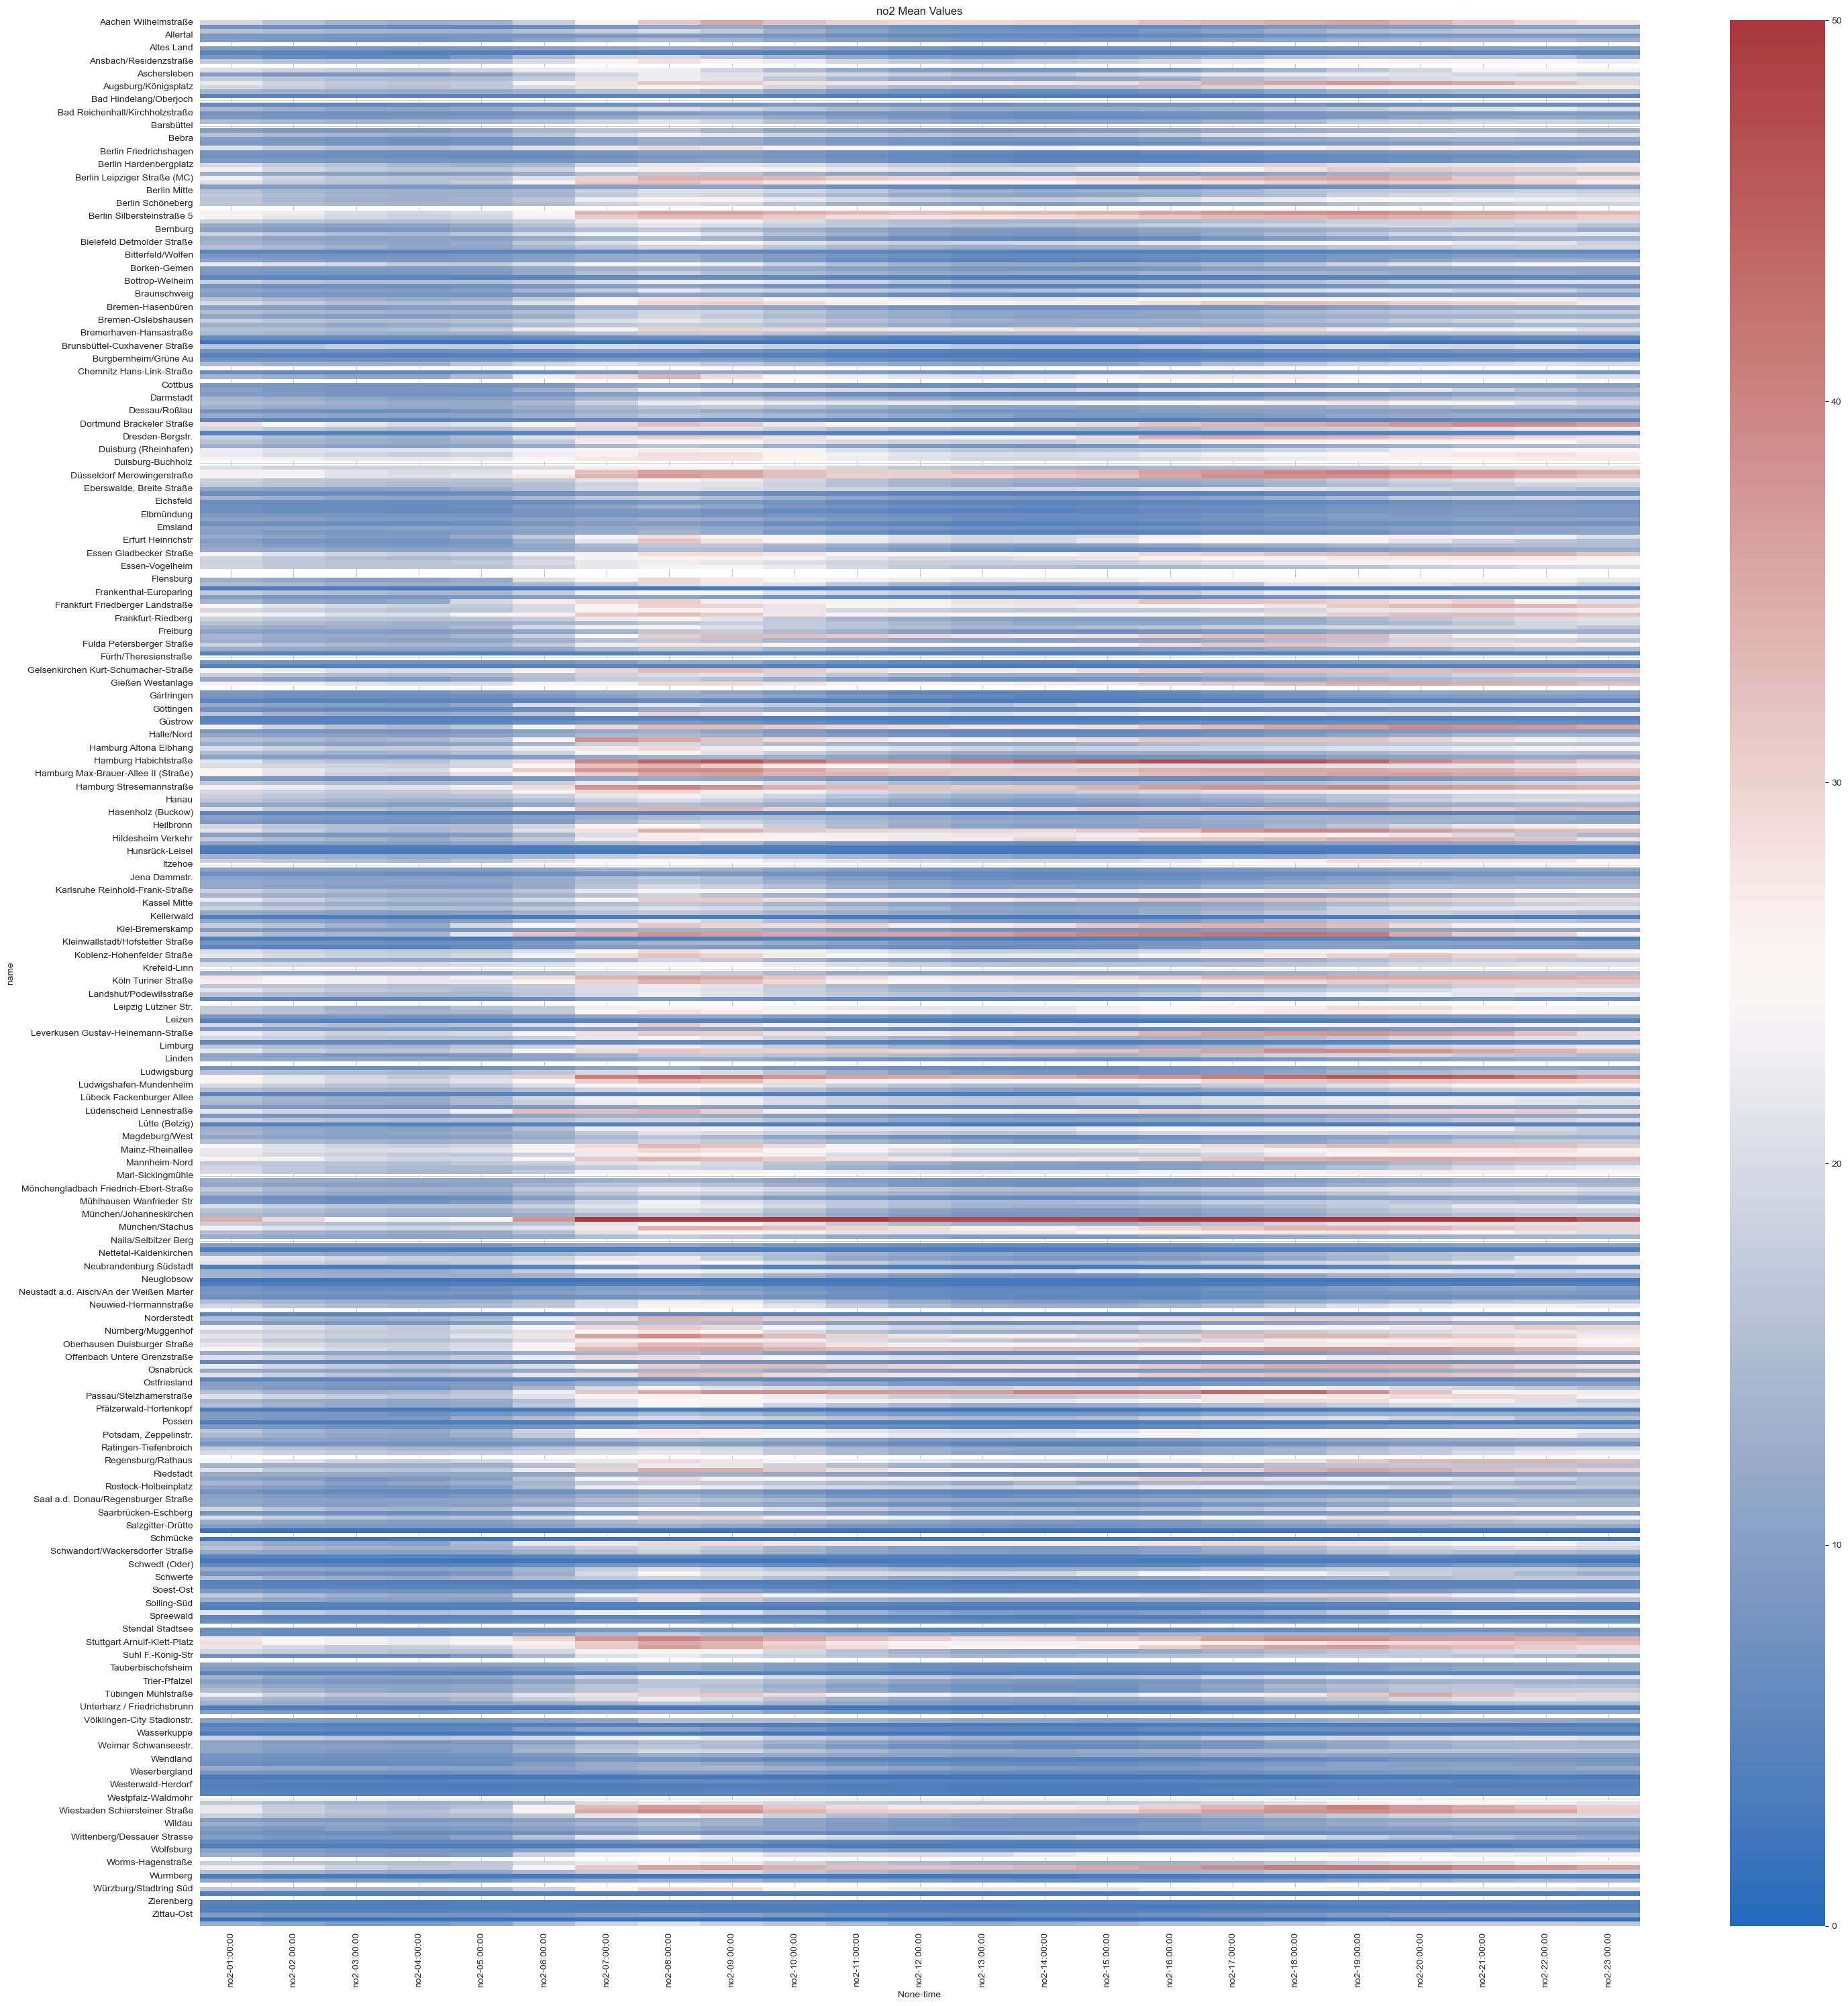

In [13]:
import matplotlib.colors as mcolors

intervall = {
    "pm10": (0,45),
    "pm25": (0,25),
    "no2": (0,50),
    "so2": (0,50),
    "o3": (0,100),


}



for col in pollutant_cols:
    fig, axes = plt.subplots(1, figsize=(30, 30))
    vmin,vmax = intervall[col]
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
  #  sns.heatmap(df[["name", "time", col]].groupby(["name", "time"]).max().unstack(), ax=axes[0], cmap="vlag", norm=norm)
    sns.heatmap(df[["name", "time", col]].groupby(["name", "time"]).mean().unstack(), ax=axes, cmap="vlag",  norm=norm)
   # sns.heatmap(df[["name", "time", col]].groupby(["name", "time"]).min().unstack(), ax=axes[2], cmap="vlag", yticklabels=False, norm=norm)

   # axes[0].set_title(f"{col} Max Values")
    axes.set_title(f"{col} Mean Values")
   # axes[2].set_title(f"{col} Min Values")

    fig.tight_layout()